In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import itertools
import time
from datetime import datetime

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [18]:
# Reading files 
df = pd.read_csv("Hotel Reservations.csv")

### Data quality check
*By Hoda Fakhari & Luna Nguyen*

In [19]:
# Total number of observations
df.shape

(36275, 19)

In [20]:
# Identifying number of missing values
print('There are', df.isnull().sum().sum(), 'missing values in the hotel reservation dataset.')

There are 0 missing values in the hotel reservation dataset.


In [21]:
# Identifying variable types to select categorical variables
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

The code below visualizes the distribution of all the continuous variables in the dataset.

In [22]:
#...Distribution of continuous variables...#
df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
no_of_previous_cancellations,36275.0,0.023349,0.368331,0.0,0.0,0.00,0.0,13.0
no_of_previous_bookings_not_canceled,36275.0,0.153411,1.754171,0.0,0.0,0.00,0.0,58.0
avg_price_per_room,36275.0,103.423539,35.089424,0.0,80.3,99.45,120.0,540.0
no_of_special_requests,36275.0,0.619655,0.786236,0.0,0.0,0.00,1.0,5.0


In [23]:
#...Distribution of categorical variables...#
for column in df[['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type']].columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns')*100)


col_0,% observations
required_car_parking_space,
0,96.901447
1,3.098553


col_0,% observations
repeated_guest,
0,97.436251
1,2.563749


col_0,% observations
arrival_month,
1,2.795314
2,4.697450
3,6.500345
4,7.542385
5,7.161957
6,8.829773
7,8.049621
8,10.511371
9,12.711234


col_0,% observations
arrival_year,
2017,17.957271
2018,82.042729


col_0,% observations
type_of_meal_plan,
Meal Plan 1,76.733287
Meal Plan 2,9.110958
Meal Plan 3,0.013784
Not Selected,14.141971


col_0,% observations
room_type_reserved,
Room_Type 1,77.546520
Room_Type 2,1.907650
Room_Type 3,0.019297
Room_Type 4,16.697450
Room_Type 5,0.730531
Room_Type 6,2.662991
Room_Type 7,0.435562


col_0,% observations
market_segment_type,
Aviation,0.344590
Complementary,1.077877
Corporate,5.560303
Offline,29.022743
Online,63.994487


The code below assesses the distribution of the the response. 

In [24]:
# Proportion of 0 and 1s in response
df.booking_status.value_counts(1)

Not_Canceled    0.672364
Canceled        0.327636
Name: booking_status, dtype: float64

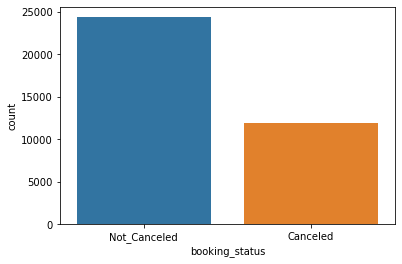

In [25]:
# Visualizing proportion of 0s and 1s in response
sns.countplot(x = 'booking_status', data = df);

### Data cleaning

Because we obtained the dataset from Kaggle, it was already cleaned and the only change we made was coding the response variable to 0 and 1 in the data preparation section.

### Data preparation
*By Hoda Fakhari & Elena Llaguno*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We converted categorical predictors to dummy variables for Variable Selection and Lasso / Ridge regression models.

2. We derived some new predictors *(from existing predictors)* that intuitively seem to be helpful to predict booking status. These were seasons and holidays.

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [26]:
######---------------Preparing Categorical Predictors----------------#########

# Convert categorical variables to dummies and append to df 
dummy_market = pd.get_dummies(df.market_segment_type)
dummy_month = pd.get_dummies(df.arrival_month)
dummy_meal = pd.get_dummies(df.type_of_meal_plan)
dummy_room = pd.get_dummies(df.room_type_reserved)

# Add dummy variables to df and drop 1 to avoid perfect multicollinearity in model 
df_dummy = pd.concat([df, dummy_market.drop('Aviation', axis = 1), dummy_month.drop(4, axis = 1), dummy_meal.drop('Meal Plan 3', axis = 1), dummy_room.drop('Room_Type 7', axis = 1)], axis = 1)
df_dummy.columns = df_dummy.columns.astype(str)

# Remove spaces from column names 
df_dummy.columns = df_dummy.columns.str.replace(' ', '')

# Convert month number to name in columns 
df_dummy.rename(columns={'1': 'January', '2': 'February', '3': 'March', 
                         '5': 'May', '6': 'June', '7': 'July', 
                        '8': 'August', '9': 'September', '10': 'October',
                        '11': 'November', '12': 'December'}, inplace=True)

# Mapping response to 0 (Not Canceled) and 1 (Canceled)
df_dummy['booking_status'] = df_dummy['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [27]:
######---------------Creating new predictors: Seasons ----------------#########

#Creating seasons
def add_seasons(data):
    data['seasons'] = data['arrival_month'].apply(lambda x: 'spring' if (x == 3 or x ==4 or x ==5) 
                                                else ('winter' if (x == 12 or x ==1 or x ==2)
                                                      else ('summer' if (x == 6 or x ==7 or x == 8)
                                                            else 'fall')))
    return data

add_seasons(df_dummy)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,MealPlan1,MealPlan2,NotSelected,Room_Type1,Room_Type2,Room_Type3,Room_Type4,Room_Type5,Room_Type6,seasons
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,1,0,0,1,0,0,0,0,0,fall
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,0,0,1,1,0,0,0,0,0,fall
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,...,1,0,0,1,0,0,0,0,0,winter
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,...,1,0,0,1,0,0,0,0,0,spring
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,...,0,0,1,1,0,0,0,0,0,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,...,1,0,0,0,0,0,1,0,0,summer
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,...,1,0,0,1,0,0,0,0,0,fall
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,...,1,0,0,1,0,0,0,0,0,summer
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,...,0,0,1,1,0,0,0,0,0,spring


In [31]:
######---------------Creating new predictors: Holiday ----------------#########

#Creating holidays 
df_dummy['holiday'] = None

# Adding New Years 
new_years = df_dummy.loc[(df_dummy['arrival_month'] == 12) & ((df_dummy['arrival_date'] == 29) | (df_dummy['arrival_date'] == 30) | (df_dummy['arrival_date'] == 31))]

for ind in new_years.index:
    df_dummy.at[ind, 'holiday'] = 'new_year'
    
    
# Adding Christmas
christmas = df_dummy.loc[(df_dummy['arrival_month'] == 12) & ((df_dummy['arrival_date'] == 23) | (df_dummy['arrival_date'] == 24) | (df_dummy['arrival_date'] == 25))]

for ind in christmas.index:
    df_dummy.at[ind, 'holiday'] = 'christmas'

    
# Adding Independence Day
independence = df_dummy.loc[(df_dummy['arrival_month'] == 7) & ((df_dummy['arrival_date'] == 2) | (df_dummy['arrival_date'] == 3) | (df_dummy['arrival_date'] == 4))]

for ind in independence.index:
    df_dummy.at[ind, 'holiday'] = 'independence'

    
# Adding Thanksgiving day 
thanksgiving = df_dummy.loc[(df_dummy['arrival_month'] == 11) & ((df_dummy['arrival_date'] == 20) | (df_dummy['arrival_date'] == 21) | (df_dummy['arrival_date'] == 22) | (df_dummy['arrival_date'] == 23))]

for ind in thanksgiving.index:
    df_dummy.at[ind, 'holiday'] = 'thanksgiving'

df_dummy['holiday'].value_counts()


new_year        478
thanksgiving    339
independence    245
christmas       221
Name: holiday, dtype: int64

In [33]:
######-----------Shuffling the dataset for K-fold------------#########

# Split train and test data 
train, test = train_test_split(df_dummy, test_size=0.25, random_state=25, shuffle=True)

In [20]:
######-----Standardizing the dataset for Lasso / Ridge-------#########
# Standardization was performed prior to running the Ridge and Lasso models in Section 3. 

## Exploratory data analysis

### Relationship between Predictors and Response
*By Hoda Fakhari*

The code below determines the correlation of continuous variables with each other and the response and visualizes the association of continuous and categorical variables with the response. 

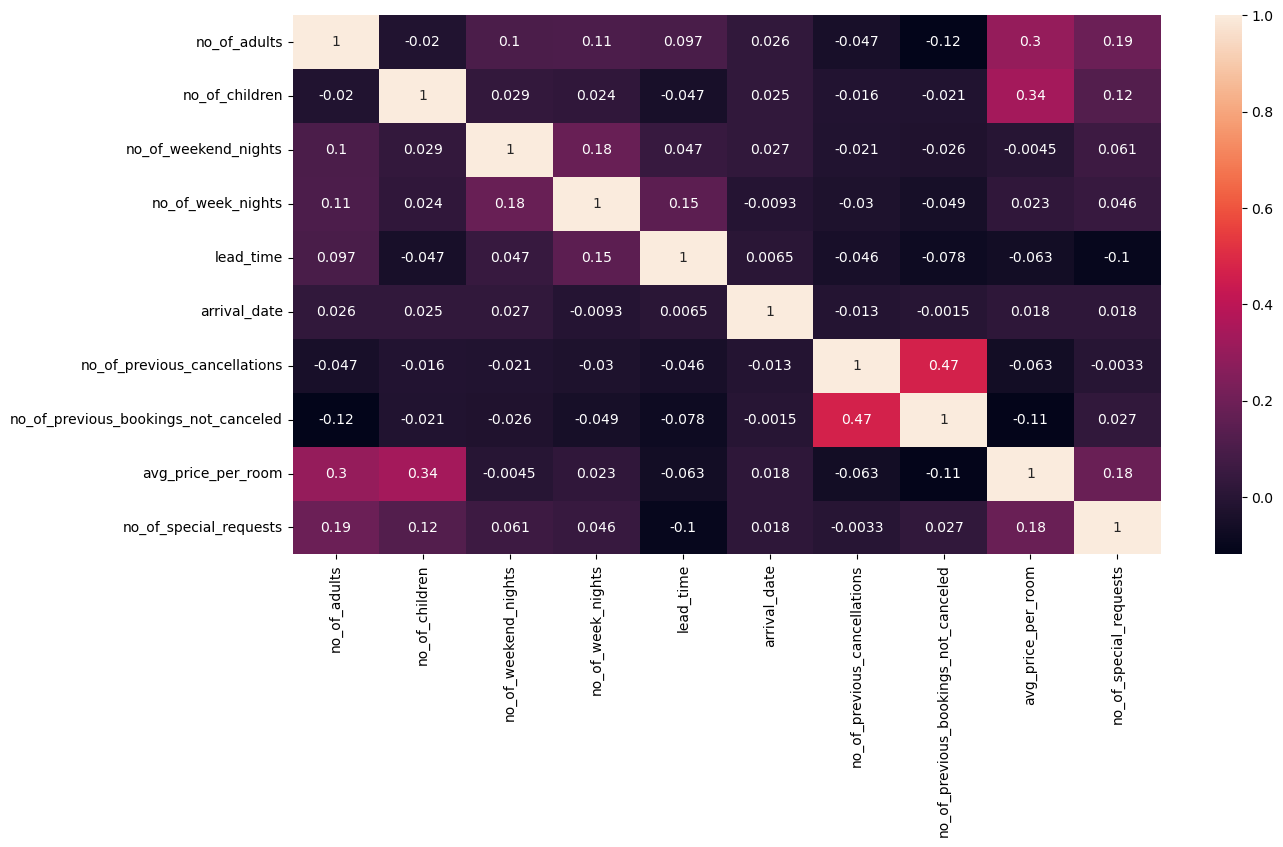

In [21]:
# Determining correlations between continuous predictors
plt.figure(figsize = (14,7));
sns.heatmap(df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).corr(), annot = True);

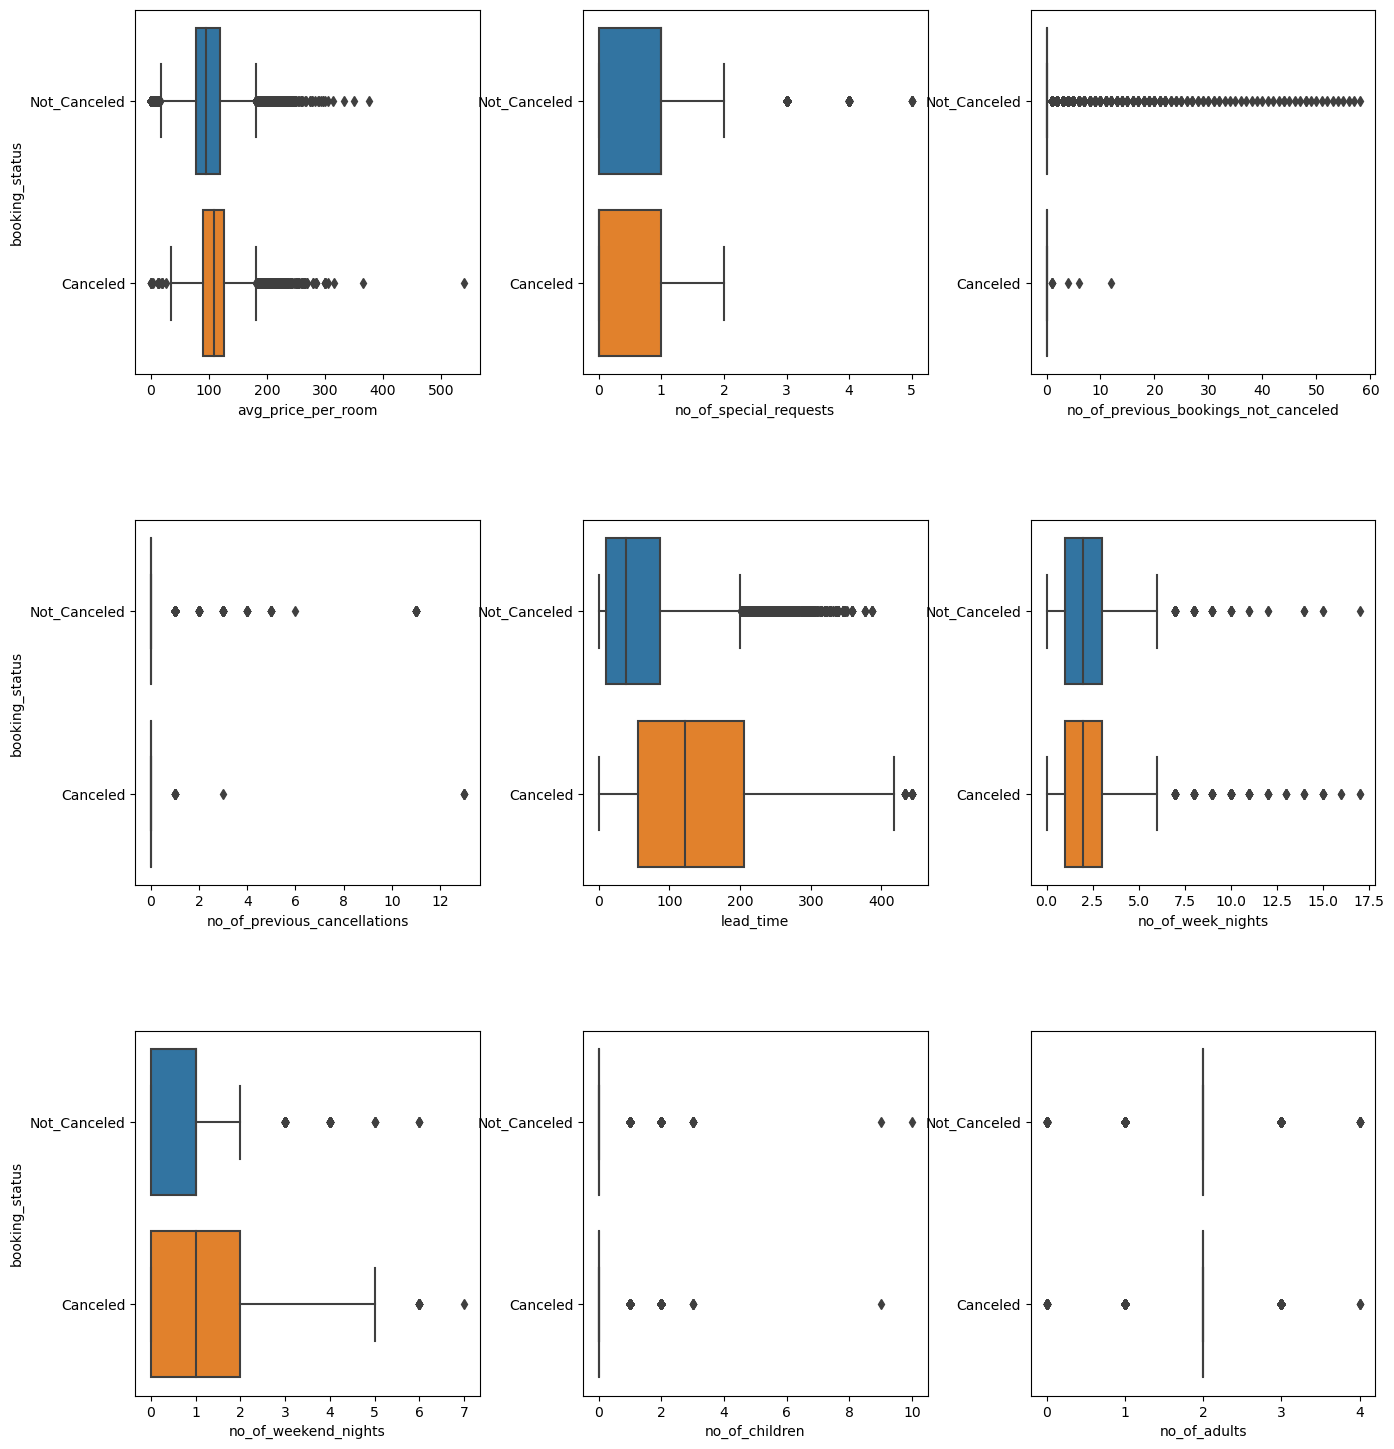

In [22]:
# Relationship between continuous variables and response
fig, ax = plt.subplots(3, 3, figsize=(16, 18));
plt.subplots_adjust(hspace = 0.4, wspace = 0.3);

sns.boxplot(data=df, x ='avg_price_per_room', y ='booking_status', ax=ax[0, 0]);
sns.boxplot(data=df, x ='no_of_special_requests', y ='booking_status', ax=ax[0, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_previous_bookings_not_canceled', y ='booking_status', ax=ax[0, 2]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_previous_cancellations', y ='booking_status', ax=ax[1, 0]);
sns.boxplot(data=df, x ='lead_time', y ='booking_status', ax=ax[1, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_week_nights', y ='booking_status', ax=ax[1, 2]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_weekend_nights', y ='booking_status', ax=ax[2, 0]);
sns.boxplot(data=df, x ='no_of_children', y ='booking_status', ax=ax[2, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_adults', y ='booking_status', ax=ax[2, 2]).set(ylabel=None);

In [14]:
# Mapping response to 0 (Not Canceled) and 1 (Canceled)
df['booking_status'].replace(['Canceled', 'Not_Canceled'],[1, 0], inplace=True)

In [19]:
# Correlation of categorical variables with response
df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).corrwith(df.booking_status)

no_of_adults                            0.086920
no_of_children                          0.033078
no_of_weekend_nights                    0.061563
no_of_week_nights                       0.092996
lead_time                               0.438538
arrival_date                            0.010629
no_of_previous_cancellations           -0.033728
no_of_previous_bookings_not_canceled   -0.060179
avg_price_per_room                      0.142569
no_of_special_requests                 -0.253070
booking_status                          1.000000
dtype: float64

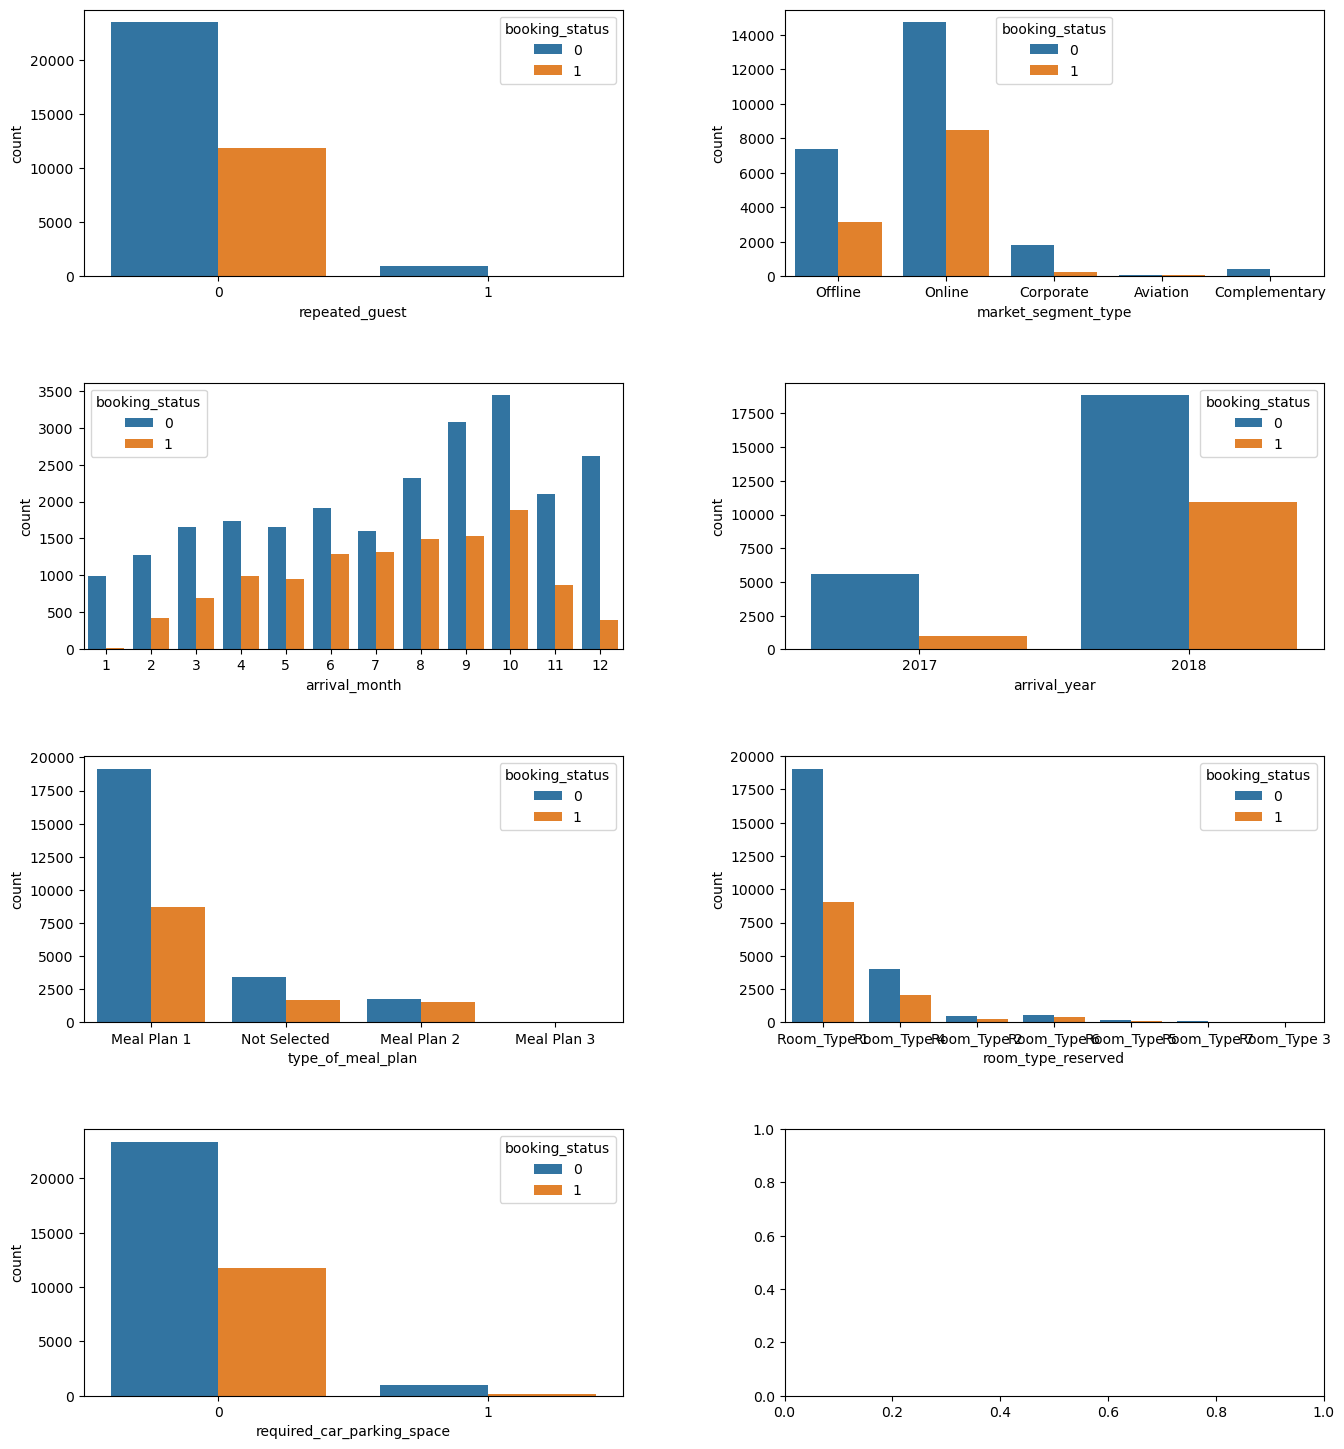

In [25]:
# Relationship between categorical variables and response
fig, ax = plt.subplots(4, 2, figsize=(16, 18));
plt.subplots_adjust(hspace = 0.4, wspace = 0.3);

sns.countplot(data=df, x ='repeated_guest', hue="booking_status", ax=ax[0, 0]);
sns.countplot(data=df, x='market_segment_type',hue='booking_status', ax=ax[0, 1]);
sns.countplot(data=df, x="arrival_month", hue="booking_status", ax=ax[1,0]);
sns.countplot(data=df, x="arrival_year",   hue="booking_status", ax=ax[1,1]);
sns.countplot(data=df, x="type_of_meal_plan",   hue="booking_status", ax=ax[2,0]);
sns.countplot(data=df, x="room_type_reserved",   hue="booking_status", ax=ax[2,1]);
sns.countplot(data=df, x="required_car_parking_space",   hue="booking_status", ax=ax[3,0]);

In [21]:
df_dummy.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6'],
      dtype='object')

In [20]:
# Correlation of categorical variables with response
df_dummy[['Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6', 'required_car_parking_space', 'repeated_guest']].corrwith(df.booking_status)

Complementary                -0.072867
Corporate                    -0.112993
Offline                      -0.038351
Online                        0.106362
January                      -0.109825
February                     -0.035613
March                        -0.017288
May                           0.022049
June                          0.050010
July                          0.077138
August                        0.045717
September                     0.004808
October                       0.022910
November                     -0.021680
December                     -0.124947
MealPlan1                    -0.061267
MealPlan2                     0.086370
NotSelected                   0.003072
Room_Type1                   -0.020326
Room_Type2                    0.000548
Room_Type3                   -0.001241
Room_Type4                    0.013309
Room_Type5                   -0.010224
Room_Type6                    0.032652
required_car_parking_space   -0.086185
repeated_guest           

### Binning of Continuous Variables
*By Hoda Fakhari* 

Highly correlated continuous/numeric variables were binned and plotted to assess the use of transformations in the models.

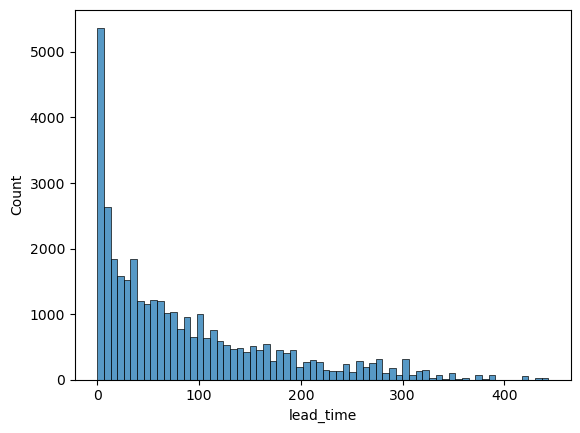

In [26]:
# Lead time distribution
sns.histplot(df.lead_time);

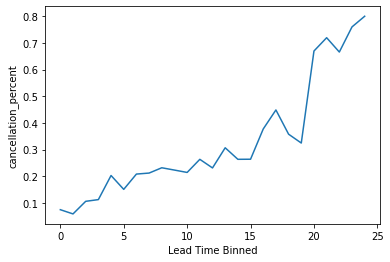

In [23]:
# Lead time
binned_lead = pd.qcut(df['lead_time'],25,retbins=True)
df['lead_binned'] = binned_lead[0]

lead_data = df.groupby('lead_binned')['booking_status'].agg([('cancellation_percent','mean'),('nobs','count')]).reset_index(drop=False);
sns.lineplot(x = lead_data.index, y= lead_data['cancellation_percent']);
plt.xlabel('Lead Time Binned');

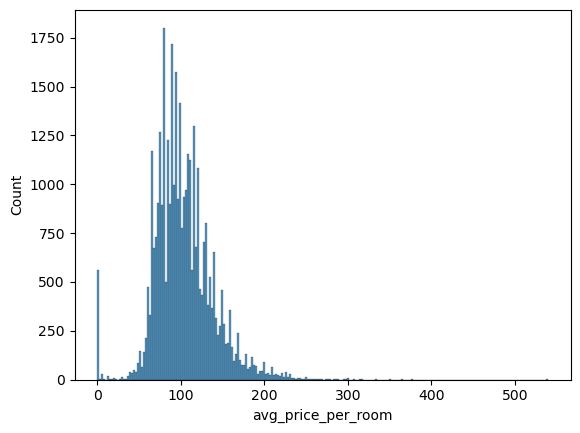

In [28]:
# Average Price per room distribution
sns.histplot(df.avg_price_per_room);

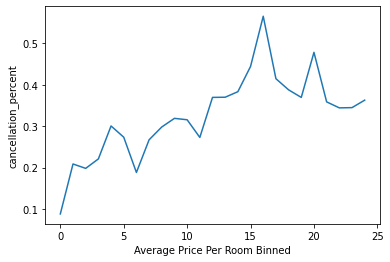

In [24]:
# Average Price per room
binned_price = pd.qcut(df['avg_price_per_room'],25,retbins=True)
df['price_binned'] = binned_price[0]

price_data = df.groupby('price_binned')['booking_status'].agg([('cancellation_percent','mean'),('nobs','count')]).reset_index(drop=False);
sns.lineplot(x = price_data.index, y= price_data['cancellation_percent']);
plt.xlabel('Average Price Per Room Binned');

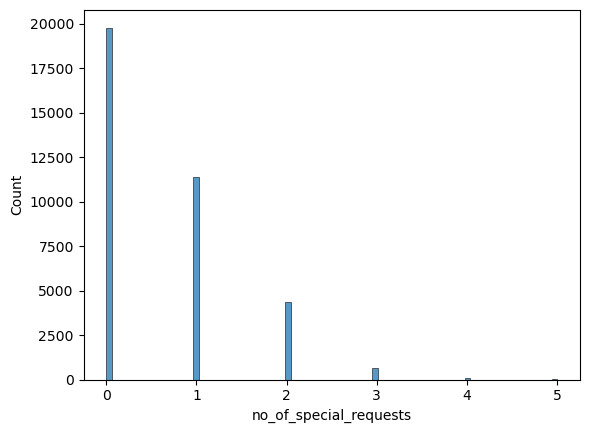

In [30]:
# Number of Special Requests Distribution
sns.histplot(df.no_of_special_requests);

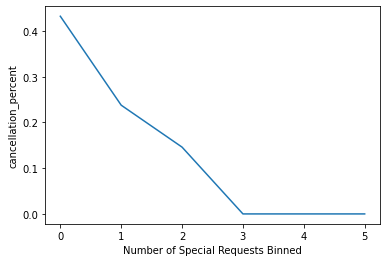

In [25]:
# Number of Special Requests
special_data = df.groupby('no_of_special_requests')['booking_status'].agg([('cancellation_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = special_data.index, y= special_data['cancellation_percent']);
plt.xlabel('Number of Special Requests Binned');

### Assessing Collinearity 

In [47]:
# Assess collinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = df_dummy[['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
        'lead_time', 'arrival_year',
       'arrival_date',  'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6']]

def vif(X):
    X = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    for i in range(len(X.columns)):
        vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

    print(vif_data)
    
vif(X)

                                 feature           VIF
0                                  const  4.328832e+07
1                           no_of_adults  1.380308e+00
2                         no_of_children  2.029636e+00
3                   no_of_weekend_nights  1.076856e+00
4                      no_of_week_nights  1.107116e+00
5             required_car_parking_space  1.041411e+00
6                              lead_time  1.535420e+00
7                           arrival_year  1.566305e+00
8                           arrival_date  1.014322e+00
9                         repeated_guest  1.765733e+00
10          no_of_previous_cancellations  1.364838e+00
11  no_of_previous_bookings_not_canceled  1.619196e+00
12                    avg_price_per_room  2.502316e+00
13                no_of_special_requests  1.255339e+00
14                         Complementary  4.429167e+00
15                             Corporate  1.661778e+01
16                               Offline  6.276770e+01
17        

In [48]:
#Remove collinear predictors one at a time
predictors = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
        'lead_time', 'arrival_year',
       'arrival_date',  'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6']
remove = ['Online']
pred_filter = [x for x in predictors if x not in remove]
X = train[pred_filter]

#Recompute VIF
vif(X)

                                 feature           VIF
0                                  const  4.345456e+07
1                           no_of_adults  1.366487e+00
2                         no_of_children  2.007348e+00
3                   no_of_weekend_nights  1.080688e+00
4                      no_of_week_nights  1.110071e+00
5             required_car_parking_space  1.041352e+00
6                              lead_time  1.532991e+00
7                           arrival_year  1.558430e+00
8                           arrival_date  1.014551e+00
9                         repeated_guest  1.763341e+00
10          no_of_previous_cancellations  1.361800e+00
11  no_of_previous_bookings_not_canceled  1.620604e+00
12                    avg_price_per_room  2.493341e+00
13                no_of_special_requests  1.245657e+00
14                         Complementary  1.383359e+00
15                             Corporate  1.526067e+00
16                               Offline  1.642687e+00
17        

In [49]:
#Remove another collinear predictor
remove = ['Online','NotSelected']
pred_filter = [x for x in predictors if x not in remove]
X = train[pred_filter]

#Recompute VIF
vif(X)

                                 feature           VIF
0                                  const  4.344544e+07
1                           no_of_adults  1.366471e+00
2                         no_of_children  2.006931e+00
3                   no_of_weekend_nights  1.080686e+00
4                      no_of_week_nights  1.110027e+00
5             required_car_parking_space  1.041213e+00
6                              lead_time  1.532981e+00
7                           arrival_year  1.558424e+00
8                           arrival_date  1.014551e+00
9                         repeated_guest  1.763339e+00
10          no_of_previous_cancellations  1.361770e+00
11  no_of_previous_bookings_not_canceled  1.620310e+00
12                    avg_price_per_room  2.492543e+00
13                no_of_special_requests  1.245655e+00
14                         Complementary  1.374004e+00
15                             Corporate  1.525922e+00
16                               Offline  1.642585e+00
17        

In [50]:
#Remove another collinear predictor
remove = ['Online','NotSelected', 'Room_Type6']
pred_filter = [x for x in predictors if x not in remove]
X = train[pred_filter]

#Recompute VIF
vif(X)

                                 feature           VIF
0                                  const  4.341377e+07
1                           no_of_adults  1.365690e+00
2                         no_of_children  1.941832e+00
3                   no_of_weekend_nights  1.080658e+00
4                      no_of_week_nights  1.110005e+00
5             required_car_parking_space  1.041212e+00
6                              lead_time  1.532612e+00
7                           arrival_year  1.557454e+00
8                           arrival_date  1.014544e+00
9                         repeated_guest  1.763253e+00
10          no_of_previous_cancellations  1.360963e+00
11  no_of_previous_bookings_not_canceled  1.620247e+00
12                    avg_price_per_room  2.492176e+00
13                no_of_special_requests  1.244118e+00
14                         Complementary  1.356061e+00
15                             Corporate  1.525607e+00
16                               Offline  1.641829e+00
17        

In [51]:
#Remove another collinear predictor
remove = ['Online','NotSelected', 'Room_Type6', 'Room_Type1']
pred_filter = [x for x in predictors if x not in remove]
X = train[pred_filter]

#Recompute VIF
vif(X)

                                 feature           VIF
0                                  const  4.311461e+07
1                           no_of_adults  1.359683e+00
2                         no_of_children  1.321435e+00
3                   no_of_weekend_nights  1.080096e+00
4                      no_of_week_nights  1.109411e+00
5             required_car_parking_space  1.041212e+00
6                              lead_time  1.529611e+00
7                           arrival_year  1.546337e+00
8                           arrival_date  1.014491e+00
9                         repeated_guest  1.761436e+00
10          no_of_previous_cancellations  1.360915e+00
11  no_of_previous_bookings_not_canceled  1.620057e+00
12                    avg_price_per_room  2.262369e+00
13                no_of_special_requests  1.241860e+00
14                         Complementary  1.300646e+00
15                             Corporate  1.523493e+00
16                               Offline  1.640851e+00
17        

### Autocorrelation 
*By Luna Nguyen*

In [32]:
# Checking for the number of reservations cancelled and not cancelled every month
monthly_cancel = df.groupby(df.arrival_month).booking_status.value_counts()

# Creating a dataframe with the number of reservations cancelled and not cancelled for every month
monthly_cancel = pd.DataFrame({'Did not cancel': [990, 1274, 1658, 1741, 1650, 1912, 1606, 2325, 3073, 3437, 2105, 2619],
                   'Cancelled': [24, 430, 700, 995, 948, 1291, 1314, 1488, 1538, 1880, 875, 402]}, 
                  index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

In [33]:
# Create a dataframe wiht the percentage of reservations cancelled and not cancelled for every month
monthly_cancel_percent = monthly_cancel.copy()
monthly_cancel_percent['Total'] = monthly_cancel_percent['Did not cancel'] + monthly_cancel_percent['Cancelled']
monthly_cancel_percent['Did not cancel percent'] = monthly_cancel_percent['Did not cancel']/monthly_cancel_percent['Total']
monthly_cancel_percent['Cancel percent'] = monthly_cancel_percent['Cancelled']/monthly_cancel_percent['Total']
monthly_cancel_percent = monthly_cancel_percent.drop(['Did not cancel', 'Cancelled', 'Total'], axis = 1)

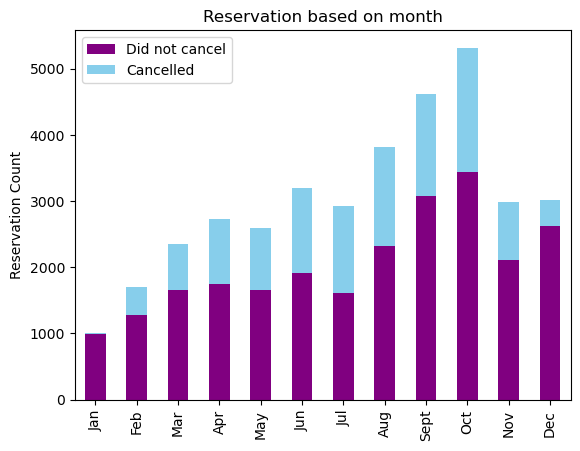

In [34]:
# Count of cancellations by month
monthly_cancel.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Reservation Count")
plt.title("Reservation based on month")
plt.show()

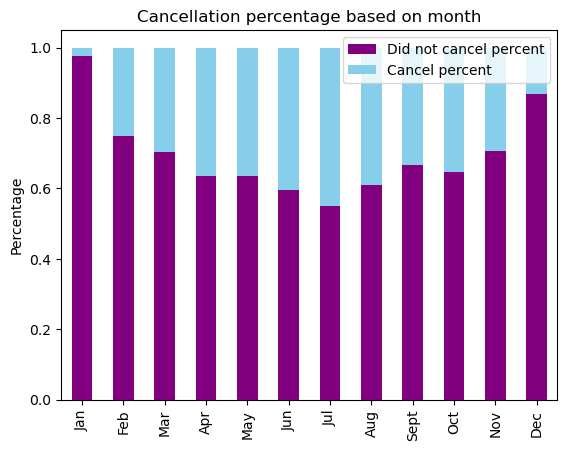

In [35]:
# Proportion of cancellations by month
monthly_cancel_percent.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Percentage")
plt.title('Cancellation percentage based on month')
plt.show()

### New Variables EDA 
*By Elena Llaguno*

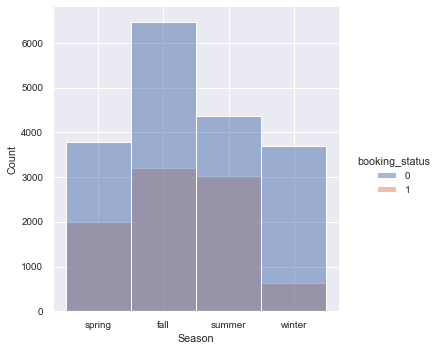

In [34]:
sns.set(font_scale = .9)
a = sns.displot(data = train, x = 'seasons',kind = 'hist', hue = 'booking_status')
a.set_axis_labels("Season", "Count")
a.set_titles("{col_name}")

In [35]:
observations_2 = (train['seasons'].value_counts()/train['seasons'].value_counts().sum())*100

df_2 = pd.DataFrame({'seasons': observations_2.index, '% observations': observations_2.values})
df_2

,seasons,% observations
0,fall,35.606116
1,summer,27.221936
2,spring,21.237962
3,winter,15.933985


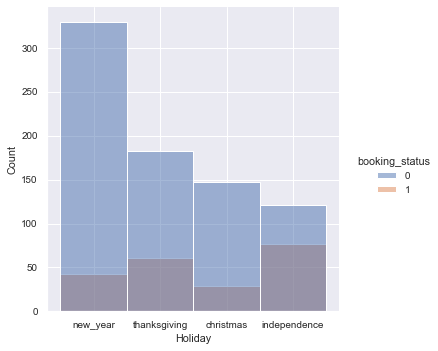

In [36]:
sns.set(font_scale = .9)
a = sns.displot(data = train, x = 'holiday',kind = 'hist', hue = 'booking_status')
a.set_axis_labels("Holiday", "Count")
a.set_titles("{col_name}")

In [37]:
observations = (train['holiday'].value_counts()/train['holiday'].value_counts().sum())*100

df = pd.DataFrame({'holiday': observations.index, '% observations': observations.values})
df

,holiday,% observations
0,new_year,37.638749
1,thanksgiving,24.621594
2,independence,19.979818
3,christmas,17.759839


## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [8]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

### Model 1) Baseline Model 
*By Kiara Villalobos-Hernandez*

In [109]:
# Model 1) Baseline Model
logit_model = sm.logit(formula = 'booking_status ~ no_of_adults + no_of_children  + no_of_weekend_nights + no_of_week_nights + type_of_meal_plan + required_car_parking_space + room_type_reserved +lead_time  + market_segment_type +repeated_guest + no_of_previous_cancellations + avg_price_per_room  + no_of_special_requests', data = train).fit()
logit_model.summary()

         Current function value: 0.422758
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27182
Method:                           MLE   Df Model:                           23
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3301
Time:                        12:59:01   Log-Likelihood:                -11502.
converged:                      False   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -3.0608      0.247    -12.408      0.000      -3.544      -2.577
type_of_meal_plan[T.Meal Plan 2]         0.0878      0.062      1.424      0.154      -0.033       0.209
type_of_meal_plan[T.Meal Plan 3]         3.4190   6.34e+04   5.39e-05      1.000   -1.24e+05    1.24e+05
type_of_meal_plan[T.Not Selected]        0.2763      0.051      5.440      0.000       0.177       0.376
room_type_reserved[T.Room_Type 2]       -0.3331      0.128     -2.602      0.009      -0.584      -0.082
room_type_reserved[T.Room_Type 3]        0.6164      1.596      0.386      0.699      -2.512       3.745
room_type_reserved[T.Room_Type 4]       -0.2370      0.052     -4.593      0.000      -0.338      -0.136
room_type_reserved[T.Room_Type 5]       -0.8168      0.201     -4.069      0.000      -1.210      -0.423
room_type_reserved[T.Room_Type 6]       -1.0549      0.146     -7.218      0.000      -1.341      -0.768
room_type_reserved[T.Room_Type 7]       -1.3978      0.296     -4.721      0.000      -1.978      -0.817
market_segment_type[T.Complementary]   -21.7108   6679.484     -0.003      0.997   -1.31e+04    1.31e+04
market_segment_type[T.Corporate]        -1.0148      0.251     -4.035      0.000      -1.508      -0.522
market_segment_type[T.Offline]          -2.0496      0.241     -8.508      0.000      -2.522      -1.577
market_segment_type[T.Online]           -0.1827      0.238     -0.768      0.442      -0.649       0.283
no_of_adults                             0.0873      0.036      2.393      0.017       0.016       0.159
no_of_children                           0.1514      0.057      2.666      0.008       0.040       0.263
no_of_weekend_nights                     0.1278      0.019      6.671      0.000       0.090       0.165
no_of_week_nights                        0.0417      0.012      3.521      0.000       0.018       0.065
required_car_parking_space              -1.7151      0.141    -12.185      0.000      -1.991      -1.439
lead_time                                0.0159      0.000     64.764      0.000       0.015       0.016
repeated_guest                          -2.3456      0.446     -5.257      0.000      -3.220      -1.471
no_of_previous_cancellations             0.2366      0.066      3.599      0.000       0.108       0.365
avg_price_per_room                       0.0197      0.001     28.802      0.000       0.018       0.021
no_of_special_requests                  -1.5371      0.029    -52.521      0.000      -1.594      -1.480
========================================================================================================
"""

Classification accuracy = 79.6%
Precision = 67.7%
TPR or Recall = 71.4%
FNR = 28.6%
FPR = 16.4%
ROC-AUC = 86.4%


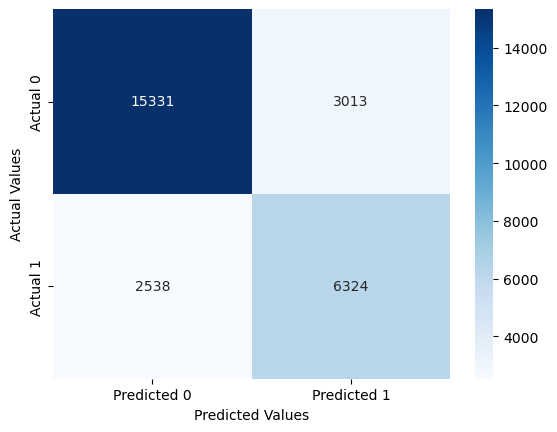

In [38]:
# Evaluating Model 1 on train data
confusion_matrix_data(train, train.booking_status, logit_model, cutoff = 0.4)

Classification accuracy = 78.7%
Precision = 67.7%
TPR or Recall = 68.9%
FNR = 31.1%
FPR = 16.5%
ROC-AUC = 85.4%


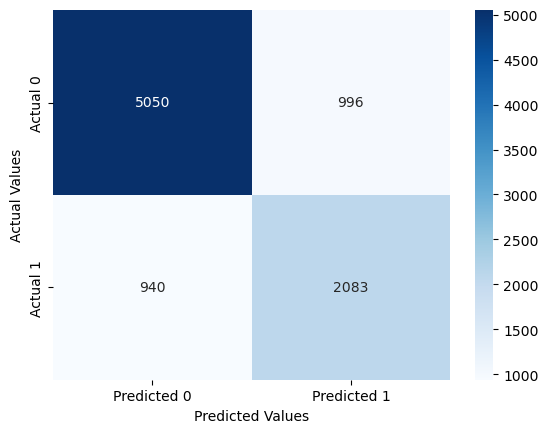

In [39]:
# Evaluating Model 1 on test data
confusion_matrix_data(test, test.booking_status, logit_model, cutoff = 0.4)

In [110]:
#Predict the values using the Model 1 (Baseline)
pred_values_1 = logit_model.predict(test)

#### Baseline Model with New Variables
*By Elena Llaguno*

In [42]:
logit_model_NEW = sm.logit(formula = 'booking_status ~ no_of_adults + no_of_children  + no_of_weekend_nights + no_of_week_nights + type_of_meal_plan + required_car_parking_space + room_type_reserved +lead_time  + market_segment_type +repeated_guest + no_of_previous_cancellations + avg_price_per_room  + no_of_special_requests + seasons ', data = train).fit()
logit_model_NEW.summary()

         Current function value: 0.419233
         Iterations: 35


/Users/elenallaguno/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27179
Method:                           MLE   Df Model:                           26
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3357
Time:                        18:15:34   Log-Likelihood:                -11406.
converged:                      False   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.9242      0.249    -11.727      0.000      -3.413      -2.435
type_of_meal_plan[T.Meal Plan 2]         0.1145      0.061      1.862      0.063      -0.006       0.235
type_of_meal_plan[T.Meal Plan 3]         2.9928   5.43e+04   5.51e-05      1.000   -1.06e+05    1.06e+05
type_of_meal_plan[T.Not Selected]        0.2641      0.051      5.159      0.000       0.164       0.364
room_type_reserved[T.Room_Type 2]       -0.2940      0.130     -2.259      0.024      -0.549      -0.039
room_type_reserved[T.Room_Type 3]        0.5184      1.581      0.328      0.743      -2.580       3.616
room_type_reserved[T.Room_Type 4]       -0.2179      0.052     -4.213      0.000      -0.319      -0.117
room_type_reserved[T.Room_Type 5]       -0.7875      0.201     -3.912      0.000      -1.182      -0.393
room_type_reserved[T.Room_Type 6]       -0.9307      0.147     -6.336      0.000      -1.219      -0.643
room_type_reserved[T.Room_Type 7]       -1.2351      0.297     -4.159      0.000      -1.817      -0.653
market_segment_type[T.Complementary]   -21.3366   5793.902     -0.004      0.997   -1.14e+04    1.13e+04
market_segment_type[T.Corporate]        -0.8562      0.253     -3.389      0.001      -1.351      -0.361
market_segment_type[T.Offline]          -1.9121      0.242     -7.904      0.000      -2.386      -1.438
market_segment_type[T.Online]           -0.0333      0.239     -0.139      0.889      -0.502       0.435
seasons[T.spring]                        0.1025      0.045      2.275      0.023       0.014       0.191
seasons[T.summer]                       -0.0440      0.042     -1.053      0.293      -0.126       0.038
seasons[T.winter]                       -0.7177      0.062    -11.523      0.000      -0.840      -0.596
no_of_adults                             0.1037      0.037      2.812      0.005       0.031       0.176
no_of_children                           0.1975      0.057      3.469      0.001       0.086       0.309
no_of_weekend_nights                     0.1277      0.019      6.616      0.000       0.090       0.166
no_of_week_nights                        0.0478      0.012      3.992      0.000       0.024       0.071
required_car_parking_space              -1.6931      0.141    -11.998      0.000      -1.970      -1.417
lead_time                                0.0156      0.000     62.265      0.000       0.015       0.016
repeated_guest                          -2.3253      0.446     -5.210      0.000      -3.200      -1.451
no_of_previous_cancellations             0.2563      0.070      3.647      0.000       0.119       0.394
avg_price_per_room                       0.0175      0.001     24.550      0.000       0.016       0.019
no_of_special_requests                  -1.5357      0.030    -51.960      0.000      -1.594      -1.478
===========================================================================================

In [39]:
# Evaluating Model 1 on train data
confusion_matrix_data(train, train.booking_status, logit_model_NEW, cutoff = 0.4)

NameError: name 'confusion_matrix_data' is not defined

In [ ]:
# Evaluating Model 1 on test data
confusion_matrix_data(test, test.booking_status, logit_model, cutoff = 0.4)

#### Identifying Outliers, High Leverage, and Influential Points

In [29]:
#Studentized residuals
out = logit_model.outlier_test()
out

AttributeError: 'LogitResults' object has no attribute 'outlier_test'

### Model 2) EDA-Based
*By Hoda Fakhari*

In [111]:
# Model 2) EDA-Based Logit Model 
eda_model = sm.logit('booking_status ~ np.log(lead_time+1) + np.log(avg_price_per_room+1) + no_of_special_requests', data = train).fit()
eda_model.summary()

Optimization terminated successfully.
         Current function value: 0.478240
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27202
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.2422
Time:                        12:59:13   Log-Likelihood:                -13011.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -13.4977      0.288    -46.883      0.000     -14.062     -12.933
np.log(lead_time + 1)              0.8436      0.015     57.079      0.000       0.815       0.873
np.log(avg_price_per_room + 1)     2.1477      0.058     37.061      0.000       2.034       2.261
no_of_special_requests            -1.0933      0.024    -45.054      0.000      -1.141      -1.046
==================================================================================================
"""

Classification accuracy = 75.6%
Precision = 60.9%
TPR or Recall = 70.5%
FNR = 29.5%
FPR = 21.9%
ROC-AUC = 82.2%


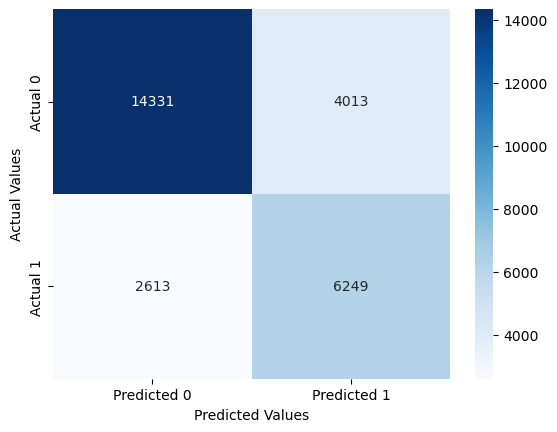

In [42]:
# Evaluating Model 2 on train data
confusion_matrix_data(train, train.booking_status, eda_model, cutoff = 0.4)

Classification accuracy = 74.9%
Precision = 60.9%
TPR or Recall = 68.7%
FNR = 31.3%
FPR = 22.0%
ROC-AUC = 81.1%


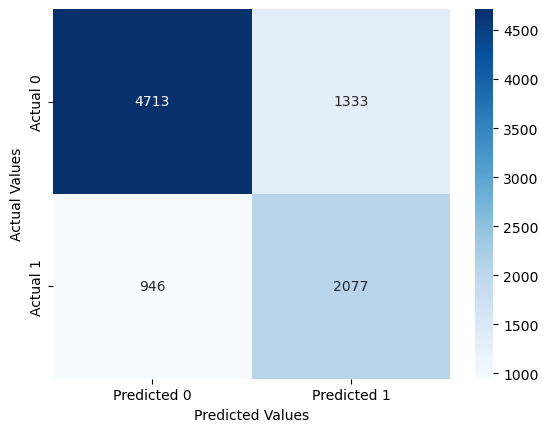

In [43]:
# Evaluating Model 2 on test data
confusion_matrix_data(test, test.booking_status, eda_model, cutoff = 0.4)

In [112]:
#Predict the values using the EDA-Based Logit model
pred_values_2 = eda_model.predict(test)

#### Additional EDA-Based Model Attempts

In [12]:
# Additional attempts at EDA-based models  
# - did not perform better than simpler EDA-based model 
# - so the former was chosen for inclusion in final model equation

#EDA-based model adding a significant categorical predictor to the original EDA-based model 
eda_model_2 = sm.logit('booking_status~no_of_special_requests+np.log(lead_time+1)+\
np.log(avg_price_per_room+1)+repeated_guest', data = train).fit()
eda_model_2.summary()

Optimization terminated successfully.
         Current function value: 0.477393
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27201
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.2436
Time:                        09:41:19   Log-Likelihood:                -12988.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -13.2805      0.289    -45.880      0.000     -13.848     -12.713
no_of_special_requests            -1.0946      0.024    -45.130      0.000      -1.142      -1.047
np.log(lead_time + 1)              0.8323      0.015     56.000      0.000       0.803       0.861
np.log(avg_price_per_room + 1)     2.1133      0.058     36.362      0.000       1.999       2.227
repeated_guest                    -1.5566      0.284     -5.477      0.000      -2.114      -1.000
==================================================================================================
"""

Classification accuracy = 75.0%
Precision = 61.1%
TPR or Recall = 68.9%
FNR = 31.1%
FPR = 21.9%
ROC-AUC = 81.4%


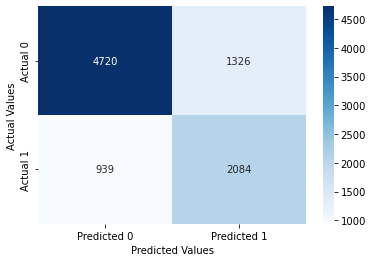

In [13]:
# Evaluating EDA model 2 on test data
confusion_matrix_data(test, test.booking_status, eda_model_2, cutoff = 0.4)

In [26]:
# EDA-Based Model with interactions based on observed correlations/intuition 
eda_model_3 = sm.logit('booking_status~no_of_special_requests+np.log(lead_time+1)+\
np.log(avg_price_per_room+1)+np.log(avg_price_per_room+1)*no_of_adults+np.log(avg_price_per_room+1)*no_of_children+\
np.log(avg_price_per_room+1)*no_of_weekend_nights + np.log(avg_price_per_room+1)*no_of_week_nights', data = train).fit()
eda_model_3.summary()

Optimization terminated successfully.
         Current function value: 0.475480
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27194
Method:                           MLE   Df Model:                           11
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.2466
Time:                        11:10:20   Log-Likelihood:                -12936.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                             -16.0051      1.106    -14.471      0.000     -18.173     -13.837
no_of_special_requests                                 -1.1431      0.025    -45.650      0.000      -1.192      -1.094
np.log(lead_time + 1)                                   0.8270      0.015     54.933      0.000       0.798       0.857
np.log(avg_price_per_room + 1)                          2.6006      0.236     11.008      0.000       2.138       3.064
no_of_adults                                            1.3327      0.504      2.646      0.008       0.346       2.320
np.log(avg_price_per_room + 1):no_of_adults            -0.2565      0.107     -2.405      0.016      -0.466      -0.047
no_of_children                                          1.4859      0.524      2.838      0.005       0.460       2.512
np.log(avg_price_per_room + 1):no_of_children          -0.2821      0.105     -2.683      0.007      -0.488      -0.076
no_of_weekend_nights                                    0.6953      0.288      2.417      0.016       0.132       1.259
np.log(avg_price_per_room + 1):no_of_weekend_nights    -0.1163      0.062     -1.876      0.061      -0.238       0.005
no_of_week_nights                                      -0.2499      0.176     -1.418      0.156      -0.595       0.095
np.log(avg_price_per_room + 1):no_of_week_nights        0.0630      0.038      1.655      0.098      -0.012       0.138
=======================================================================================================================
"""

Classification accuracy = 74.6%
Precision = 60.6%
TPR or Recall = 68.5%
FNR = 31.5%
FPR = 22.3%
ROC-AUC = 81.4%


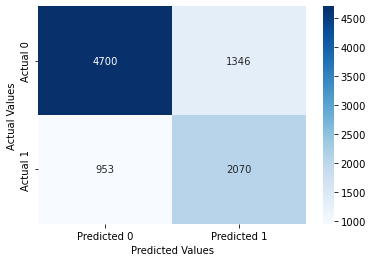

In [27]:
# Evaluating EDA model 3 on test data
confusion_matrix_data(test, test.booking_status, eda_model_3, cutoff = 0.4)

In [6]:
# Exploratory EDA-based model adding predictors 
eda_model_4 = sm.logit('booking_status~no_of_special_requests+np.log(lead_time+1)+no_of_weekend_nights+\
no_of_weekend_nights*no_of_week_nights+no_of_previous_cancellations+\
no_of_previous_cancellations*no_of_previous_bookings_not_canceled+\
np.log(avg_price_per_room+1)+np.log(avg_price_per_room+1)*no_of_adults+np.log(avg_price_per_room+1)*no_of_children', data = train).fit()
eda_model_4.summary()

Optimization terminated successfully.
         Current function value: 0.473369
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27192
Method:                           MLE   Df Model:                           13
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.2500
Time:                        09:26:52   Log-Likelihood:                -12878.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           -15.7306      1.040    -15.131      0.000     -17.768     -13.693
no_of_special_requests                                               -1.1354      0.025    -45.284      0.000      -1.185      -1.086
np.log(lead_time + 1)                                                 0.8423      0.015     55.044      0.000       0.812       0.872
no_of_weekend_nights                                                 -0.0626      0.029     -2.136      0.033      -0.120      -0.005
no_of_week_nights                                                    -0.0940      0.018     -5.241      0.000      -0.129      -0.059
no_of_weekend_nights:no_of_week_nights                                0.0733      0.008      9.010      0.000       0.057       0.089
no_of_previous_cancellations                                          0.0735      0.080      0.916      0.360      -0.084       0.231
no_of_previous_bookings_not_canceled                                 -0.4605      0.150     -3.079      0.002      -0.754      -0.167
no_of_previous_cancellations:no_of_previous_bookings_not_canceled     0.0368      0.019      1.962      0.050    4.17e-05       0.074
np.log(avg_price_per_room + 1)                                        2.5905      0.222     11.694      0.000       2.156       3.025
no_of_adults                                                          1.3215      0.510      2.589      0.010       0.321       2.322
np.log(avg_price_per_room + 1):no_of_adults                          -0.2485      0.108     -2.300      0.021      -0.460      -0.037
no_of_children                                                        1.5019      0.524      2.866      0.004       0.475       2.529
np.log(avg_price_per_room + 1):no_of_children                        -0.2840      0.105     -2.699      0.007      -0.490      -0.078
=====================================================================================================================================
"""

Classification accuracy = 74.7%
Precision = 60.6%
TPR or Recall = 69.2%
FNR = 30.8%
FPR = 22.5%
ROC-AUC = 81.5%


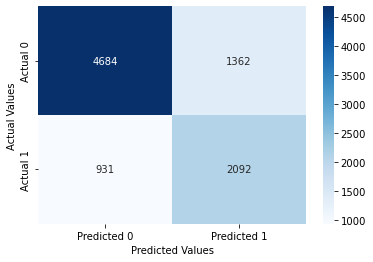

In [9]:
# Evaluating EDA model 4 on test data
confusion_matrix_data(test, test.booking_status, eda_model_4, cutoff = 0.4)

In [10]:
# Exploratory EDA-based model with interactions and binary categorical variables 
eda_model_5 = sm.logit('booking_status~no_of_special_requests+np.log(lead_time+1)+no_of_weekend_nights+\
np.log(avg_price_per_room+1)+avg_price_per_room*no_of_adults+avg_price_per_room*no_of_children+\
repeated_guest', data = train).fit()
eda_model_5.summary()

Optimization terminated successfully.
         Current function value: 0.474553
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27195
Method:                           MLE   Df Model:                           10
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.2481
Time:                        09:28:08   Log-Likelihood:                -12911.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -10.0624      0.855    -11.775      0.000     -11.737      -8.387
no_of_special_requests               -1.1408      0.025    -45.637      0.000      -1.190      -1.092
np.log(lead_time + 1)                 0.8350      0.015     54.729      0.000       0.805       0.865
no_of_weekend_nights                  0.1620      0.017      9.285      0.000       0.128       0.196
np.log(avg_price_per_room + 1)        0.8309      0.241      3.446      0.001       0.358       1.304
avg_price_per_room                    0.0222      0.003      6.527      0.000       0.016       0.029
no_of_adults                          0.6579      0.114      5.764      0.000       0.434       0.882
avg_price_per_room:no_of_adults      -0.0049      0.001     -5.108      0.000      -0.007      -0.003
no_of_children                        0.5590      0.124      4.506      0.000       0.316       0.802
avg_price_per_room:no_of_children    -0.0036      0.001     -4.454      0.000      -0.005      -0.002
repeated_guest                       -1.3909      0.285     -4.877      0.000      -1.950      -0.832
=====================================================================================================
"""

Classification accuracy = 75.0%
Precision = 61.1%
TPR or Recall = 68.9%
FNR = 31.1%
FPR = 21.9%
ROC-AUC = 81.4%


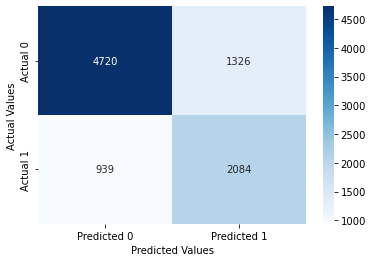

In [11]:
# Evaluating EDA model 5 on test data
confusion_matrix_data(test, test.booking_status, eda_model_3, cutoff = 0.4)

### Model 3) Variable Selection
*By Hoda Fakhari*

In [52]:
# Model 3) Forward Selection Model

# Continuous and categorical predictors accounting for collinearity based on section 2.3 
X = train [['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
        'lead_time', 'arrival_year',
       'arrival_date',  'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
        'Room_Type2', 'Room_Type3', 'Room_Type4','Room_Type5']]

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate BIC
    model = sm.logit('booking_status~' + '+'.join(predictor_subset), data = train).fit()
    BIC = model.bic
    return {"model":model, "BIC":BIC}

#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613451
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.631083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630324
 

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.630380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621856
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.530536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.534885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535234
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.497996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.503867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503918
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.459463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449420
  

Optimization terminated successfully.
         Current function value: 0.424210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423623
         Iterations 11
         Current function value: 0.423409
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.421091
         Iterations 8


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.422979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423527
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.419074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419703
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.416669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417049
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417358
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417286
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417289
  

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414578
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.415022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.415069
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.415090
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.414730
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.415034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414685
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414340
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.413900
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413717
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414181
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414222
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.414243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413910
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413849
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.413515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.413077
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413377
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413410
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412968
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412576
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.411929
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412222
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412058
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412535
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412211
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412488
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.412085
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411889
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411584
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411870
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411638
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411878
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411285
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411558
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411380
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411855
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411811
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411859
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411561
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411803
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411402
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411868
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411871
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411894
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411803
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411667
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411124
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411284
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410962
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411269
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411036
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411269
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410779
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410856
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411265
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411221
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411260
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410969
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411163
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410658
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411274
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411253
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411283
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411196
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.411050
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410459
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410658
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410366
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410624
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410406
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410643
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409980
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410317
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410655
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410625
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410651
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410417
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410457
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410643
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410631
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410656
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410584
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410414
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409834
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409977
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409733
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409959
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409726
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409965
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409749
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409976
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409970
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409979
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409789
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409691
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409978
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409947
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409977
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409896
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409728
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409520
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409689
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409410
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409666
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409431
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409677
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409523
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409668
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409691
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409679
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409596
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409686
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409662
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409689
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409604
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409434
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409249
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409409
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409381
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409147
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409397
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409237
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409385
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409410
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409400
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409323
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409407
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409381
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409408
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409298
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409142
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408986
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409139
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409114
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408878
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409128
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408959
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409119
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409142
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409133
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409063
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409140
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409113
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409140
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.409004
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408728
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408874
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408848
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408831
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408695
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408853
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408878
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408868
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408801
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408875
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408849
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408876
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408740
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408553
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408690
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408665
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408649
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408690
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408689
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408695
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408565
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408694
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408665
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408693
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408561
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408553
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408525
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408506
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408541
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408543
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408553
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408435
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408550
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408533
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408551
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408332
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408316
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408301
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408287
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408321
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408324
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408332
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408216
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408321
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408304
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408331
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408189
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408183
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408171
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408215
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408180
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408201
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408210
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408185
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408214
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408145
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408138
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408171
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408135
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408157
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408165
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408141
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408170
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408110
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408104
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408133
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408093
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408130
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408106
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408134
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408071
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408063
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408059
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408088
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408063
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408092
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408032
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408029
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408056
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408029
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408058
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408011
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407999
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408025
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.408028
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407979
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407995
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407997
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407976
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407977
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.407974
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


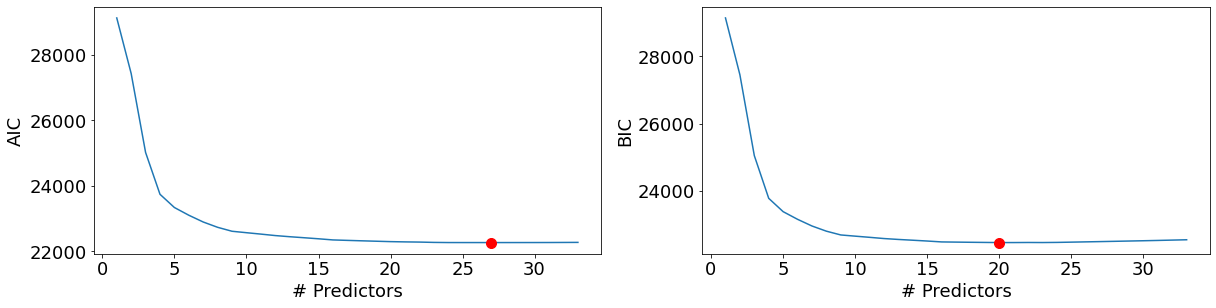

In [53]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)


    # AIC and BIC 
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 1)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

best_sub_plots()

In [54]:
best_forward_model = models_best.loc[20,'model']
best_forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27185
Method:                           MLE   Df Model:                           20
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3521
Time:                        12:08:07   Log-Likelihood:                -11124.
converged:                      False   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -1089.4361    112.235     -9.707      0.000   -1309.413    -869.459
lead_time                        0.0160      0.000     60.778      0.000       0.015       0.017
no_of_special_requests          -1.5573      0.030    -52.438      0.000      -1.616      -1.499
Offline                         -1.8331      0.047    -38.753      0.000      -1.926      -1.740
avg_price_per_room               0.0166      0.001     27.712      0.000       0.015       0.018
December                        -1.4231      0.085    -16.688      0.000      -1.590      -1.256
Corporate                       -0.8663      0.098     -8.823      0.000      -1.059      -0.674
required_car_parking_space      -1.7181      0.143    -12.055      0.000      -1.997      -1.439
January                         -2.1527      0.245     -8.781      0.000      -2.633      -1.672
arrival_year                     0.5386      0.056      9.683      0.000       0.430       0.648
repeated_guest                  -2.3712      0.457     -5.194      0.000      -3.266      -1.476
no_of_weekend_nights             0.1262      0.020      6.451      0.000       0.088       0.164
MealPlan1                       -0.2950      0.039     -7.492      0.000      -0.372      -0.218
Complementary                  -21.6720   5610.528     -0.004      0.997    -1.1e+04     1.1e+04
February                         0.6330      0.081      7.801      0.000       0.474       0.792
November                         0.4748      0.067      7.085      0.000       0.343       0.606
March                            0.4269      0.067      6.364      0.000       0.295       0.558
October                          0.2202      0.051      4.286      0.000       0.120       0.321
no_of_week_nights                0.0489      0.012      4.004      0.000       0.025       0.073
Room_Type5                      -0.7508      0.200     -3.752      0.000      -1.143      -0.359
no_of_previous_cancellations     0.2914      0.077      3.798      0.000       0.141       0.442
================================================================================================
"""

Classification accuracy = 80.1%
Precision = 68.1%
TPR or Recall = 73.1%
FNR = 26.9%
FPR = 16.5%
ROC-AUC = 87.4%


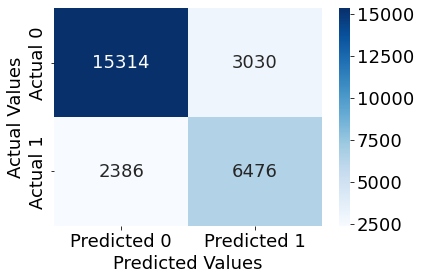

In [57]:
# Evaluating Model 3 on train data
confusion_matrix_data(train, train.booking_status, best_forward_model, cutoff = 0.4)

Classification accuracy = 79.3%
Precision = 68.4%
TPR or Recall = 70.6%
FNR = 29.4%
FPR = 16.3%
ROC-AUC = 86.3%


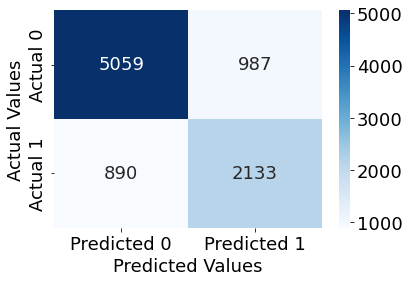

In [58]:
# Evaluating Model 3 on test data
confusion_matrix_data(test, test.booking_status, best_forward_model, cutoff = 0.4)

In [59]:
#Predict the values using the best Forward model
pred_values_3 = best_forward_model.predict(test)

In [65]:
# Backward Selection (removed more predictors to avoid singular matrix error)

X = train [['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
        'lead_time', 'arrival_year',
       'arrival_date',  'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
        'Corporate', 'Offline', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1',
        'Room_Type5', ]]

def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = backward_selection()

Optimization terminated successfully.
         Current function value: 0.408819
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.409099
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409866
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.414009
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.408826
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409051
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.408892
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.408916
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.409141
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409587
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.408962
         Iterations 12
Processed  26 models on 25 predictors in 9.177159547805786 seconds.
Optimization terminated successfully.
         Current function value: 0.409133
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409926
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.415882
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.409162
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.409304
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409011
         Iterations 12
Optim

Optimization terminated successfully.
         Current function value: 0.416102
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409609
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409385
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.409173
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409447
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.409464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.409858
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.412014
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.440154
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.409826
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410333
         Iterations 11
Processed  19 models on 18 predictors in 4.892472743988037 seconds.
Optimization terminated successfully.
         Current function value: 0.410097
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.416476
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410718
         Iterations 10
Optim

Optimization terminated successfully.
         Current function value: 0.412068
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.514171
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412296
         Iterations 10
Processed  14 models on 13 predictors in 2.694030523300171 seconds.
Optimization terminated successfully.
         Current function value: 0.412830
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.419134
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412576
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.415085
         Iterations 10
Optimi

         Current function value: 0.464219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.545678
         Iterations 6
Processed  6 models on 5 predictors in 0.6041007041931152 seconds.
Optimization terminated successfully.
         Current function value: 0.436061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449420
         Iterations 7
Optimization terminated successfully.
         Curren

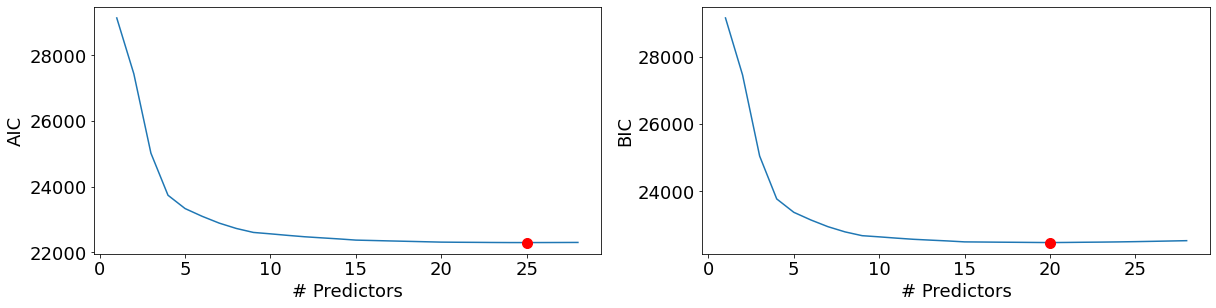

In [66]:
best_sub_plots()

In [67]:
best_backward_model = models_best.loc[20,'model']
best_backward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27185
Method:                           MLE   Df Model:                           20
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.3515
Time:                        12:28:41   Log-Likelihood:                -11135.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -969.5881    112.460     -8.622      0.000   -1190.005    -749.171
no_of_weekend_nights             0.1279      0.020      6.544      0.000       0.090       0.166
no_of_week_nights                0.0479      0.012      3.929      0.000       0.024       0.072
required_car_parking_space      -1.7624      0.143    -12.325      0.000      -2.043      -1.482
lead_time                        0.0160      0.000     61.114      0.000       0.016       0.017
arrival_year                     0.4792      0.056      8.598      0.000       0.370       0.588
repeated_guest                  -2.3787      0.455     -5.230      0.000      -3.270      -1.487
no_of_previous_cancellations     0.2895      0.077      3.743      0.000       0.138       0.441
avg_price_per_room               0.0172      0.001     28.742      0.000       0.016       0.018
no_of_special_requests          -1.5512      0.030    -52.301      0.000      -1.609      -1.493
Corporate                       -0.8112      0.098     -8.260      0.000      -1.004      -0.619
Offline                         -1.8147      0.047    -38.398      0.000      -1.907      -1.722
January                         -2.2258      0.245     -9.076      0.000      -2.706      -1.745
February                         0.5599      0.081      6.884      0.000       0.400       0.719
March                            0.3474      0.067      5.153      0.000       0.215       0.480
May                             -0.2614      0.063     -4.158      0.000      -0.385      -0.138
September                       -0.2071      0.055     -3.757      0.000      -0.315      -0.099
November                         0.3779      0.067      5.639      0.000       0.247       0.509
December                        -1.5201      0.085    -17.789      0.000      -1.688      -1.353
MealPlan1                       -0.2937      0.039     -7.452      0.000      -0.371      -0.216
Room_Type5                      -0.7571      0.199     -3.797      0.000      -1.148      -0.366
================================================================================================
"""

Classification accuracy = 80.2%
Precision = 68.4%
TPR or Recall = 73.0%
FNR = 27.0%
FPR = 16.3%
ROC-AUC = 87.4%


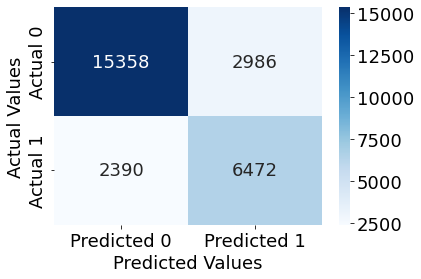

In [68]:
# Evaluating backward model on train data
confusion_matrix_data(train, train.booking_status, best_backward_model, cutoff = 0.4)

Classification accuracy = 79.3%
Precision = 68.4%
TPR or Recall = 70.4%
FNR = 29.6%
FPR = 16.3%
ROC-AUC = 86.3%


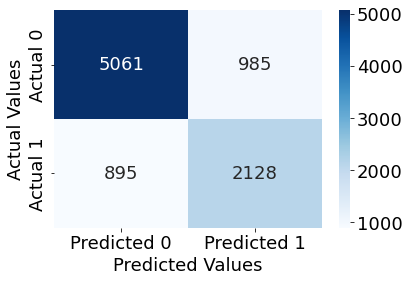

In [69]:
# Evaluating backward model on test data
confusion_matrix_data(test, test.booking_status, best_backward_model, cutoff = 0.4)

#### Variable Selection with Interactions

This approach was not successful because of additional collinearity introduced by interaction terms. Variable selection with interactions was attempted with all continuous and binary categorical variables and with 20 variables selected from the best forward selection model. 

In [75]:
best_forward_model.params.index

Index(['Intercept', 'lead_time', 'no_of_special_requests', 'Offline',
       'avg_price_per_room', 'December', 'Corporate',
       'required_car_parking_space', 'January', 'arrival_year',
       'repeated_guest', 'no_of_weekend_nights', 'MealPlan1', 'Complementary',
       'February', 'November', 'March', 'October', 'no_of_week_nights',
       'Room_Type5', 'no_of_previous_cancellations'],
      dtype='object')

In [79]:
best_backward_model.params.index

Index(['Intercept', 'no_of_weekend_nights', 'no_of_week_nights',
       'required_car_parking_space', 'lead_time', 'arrival_year',
       'repeated_guest', 'no_of_previous_cancellations', 'avg_price_per_room',
       'no_of_special_requests', 'Corporate', 'Offline', 'January', 'February',
       'March', 'May', 'September', 'November', 'December', 'MealPlan1',
       'Room_Type5'],
      dtype='object')

In [83]:
#Creating a dataframe with all continuous and binary categorical variables
X = train[['no_of_adults', 'no_of_children','no_of_weekend_nights','no_of_week_nights',
           'required_car_parking_space','lead_time','arrival_year',
            'arrival_date', 'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled','avg_price_per_room', 'no_of_special_requests']]

#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['no_of_adults', 'no_of_children','no_of_weekend_nights','no_of_week_nights',
           'required_car_parking_space','lead_time','arrival_year',
            'arrival_date', 'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled','avg_price_per_room', 'no_of_special_requests']]

In [84]:
#Including 2-factor interactions of predictors in train and 'X'. 
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\hodaf\AppData\Local\Temp\ipykernel_11204\1442374694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [85]:
# models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613451
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.631083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630324
 

C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LinAlgError: Singular matrix

### Model 4) KNN
*By Hoda Fakhari*

In [114]:
# Model 4) KNN

# Split train and test datasets
y = df_dummy.booking_status
X = df_dummy.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 'arrival_month', 'room_type_reserved'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

# KNN with all predictors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification accuracy = 86.8%
Precision = 84.5%
TPR or Recall = 72.8%
FNR = 27.2%
FPR = 6.5%
ROC-AUC = 83.2%


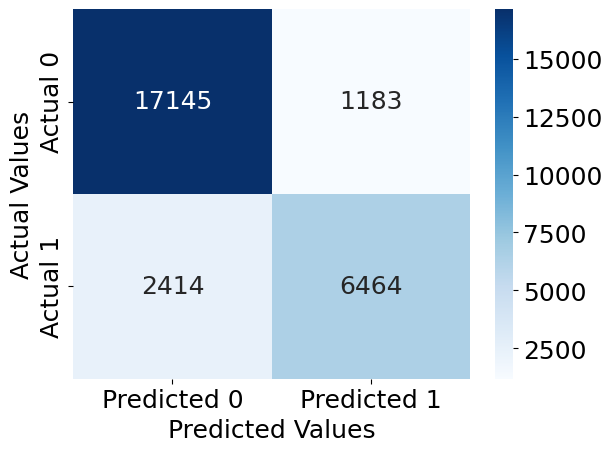

In [54]:
# Evaluating Model 4 on train data
confusion_matrix_data(X_train, y_train, knn, cutoff = 0.4)

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification accuracy = 79.6%
Precision = 73.6%
TPR or Recall = 59.9%
FNR = 40.1%
FPR = 10.7%
ROC-AUC = 74.6%


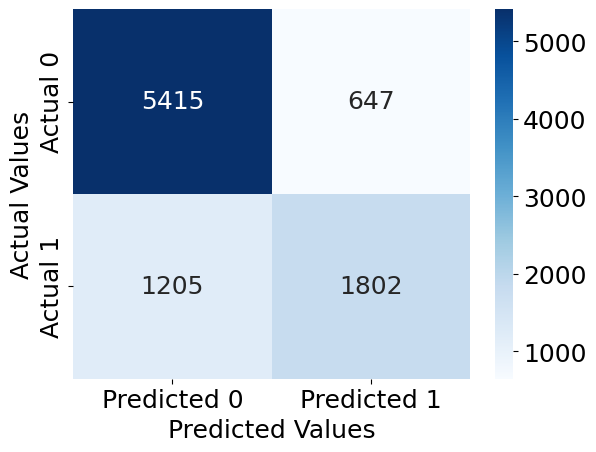

In [55]:
# Evaluating Model 4 on test data
confusion_matrix_data(X_test, y_test, knn, cutoff = 0.4)

In [115]:
#Predict the values using the Model 4 (KNN)
pred_values_4 = knn.predict(X_test)

### Model 5) KNN + Variable Selection
*By Hoda Fakhari*

In [118]:
# Model 5) KNN + Variable Selection 

# KNN with 20 features selected from forward selection 
y = df_dummy.booking_status
X = df_dummy[['lead_time', 'no_of_special_requests', 'Offline',
       'avg_price_per_room', 'December', 'Corporate',
       'required_car_parking_space', 'January', 'arrival_year',
       'repeated_guest', 'no_of_weekend_nights', 'MealPlan1', 'Complementary',
       'February', 'November', 'March', 'October', 'no_of_week_nights',
       'Room_Type5', 'no_of_previous_cancellations']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)
knn_var = KNeighborsClassifier().fit(X_train, y_train)

Classification accuracy = 87.2%
Precision = 84.3%
TPR or Recall = 74.7%
FNR = 25.3%
FPR = 6.7%
ROC-AUC = 84.0%


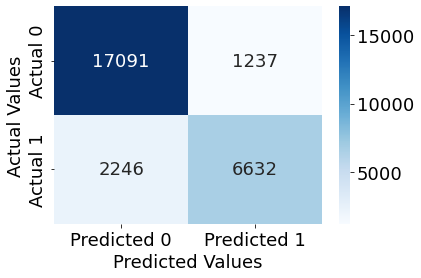

In [89]:
# Evaluating Model 5 on train data
confusion_matrix_data(X_train, y_train, knn_var, cutoff = 0.4)

Classification accuracy = 81.1%
Precision = 75.5%
TPR or Recall = 63.4%
FNR = 36.6%
FPR = 10.2%
ROC-AUC = 76.6%


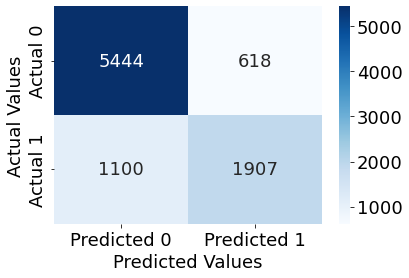

In [90]:
# Evaluating Model 5 on test data
confusion_matrix_data(X_test, y_test, knn_var, cutoff = 0.4)

In [119]:
#Predict the values using the KNN +variable selection model
pred_values_5 = knn_var.predict(X_test)

### Model 6) Ridge
*By Hoda Fakhari*

In [93]:
# Model 6) Ridge

y = train.booking_status

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = train.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space','lead_time', 'arrival_year', 
       'arrival_date', 'repeated_guest','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'Complementary', 'Corporate', 
        'Offline', 'Online', 'January','February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2','NotSelected', 
        'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4','Room_Type5', 'Room_Type6']]

#Defining a scaler object
scaler = StandardScaler()

scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#Filtering all predictors in test dataset
Xtest = test.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
       'lead_time', 'arrival_year', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6']]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)



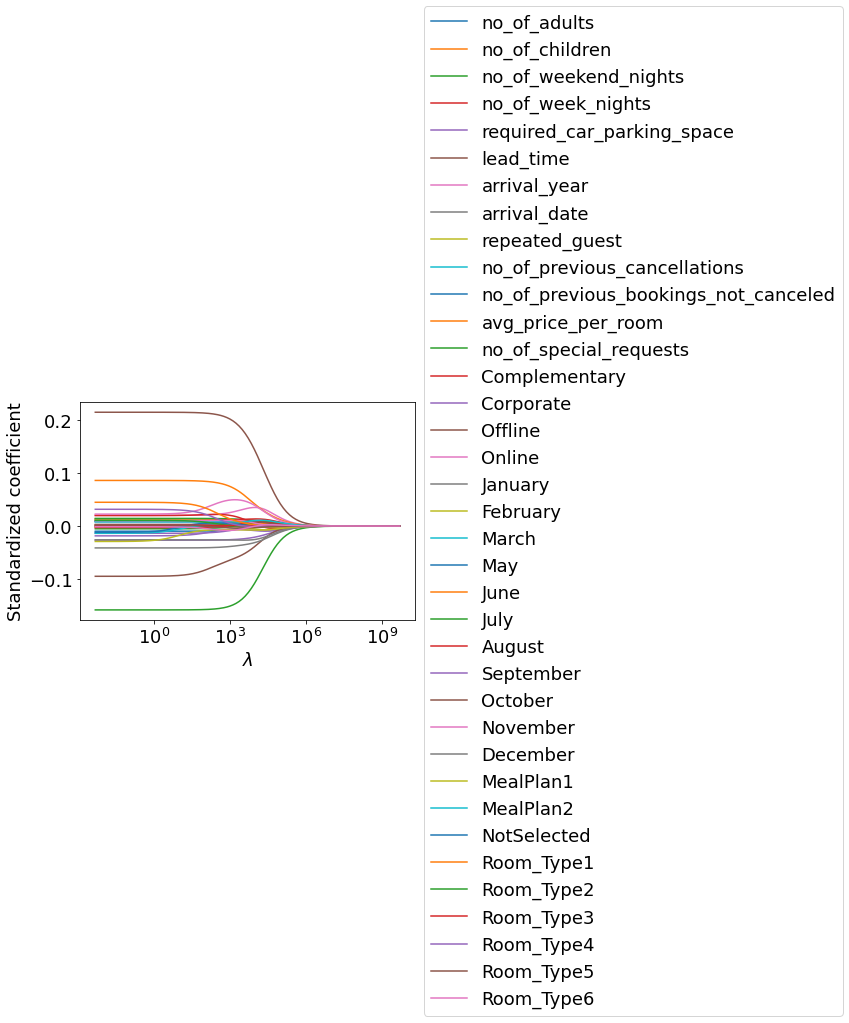

In [94]:
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 
                               'arrival_month', 'room_type_reserved']), loc='center left', bbox_to_anchor=(1, 0.5));

In [95]:
#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

15.811388300841896

In [96]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge = ridge.fit(Xstd, y)

In [97]:
ridge_coeff = pd.DataFrame(ridge.coef_, columns = ['coefficients'])
ridge_coeff['predictors'] = X.columns
ridge_coeff

,coefficients,predictors
0,0.009002,no_of_adults
1,0.013773,no_of_children
2,0.014445,no_of_weekend_nights
3,0.011074,no_of_week_nights
4,-0.026611,required_car_parking_space
5,0.214746,lead_time
6,0.020401,arrival_year
7,0.003246,arrival_date
8,0.000193,repeated_guest
9,-0.000368,no_of_previous_cancellations


In [129]:
ridge.intercept_

0.3257369697860763

Classification accuracy = 76.7%
Precision = 65.1%
TPR or Recall = 74.4%
FNR = 25.6%
FPR = 22.0%
ROC-AUC = 87.2%


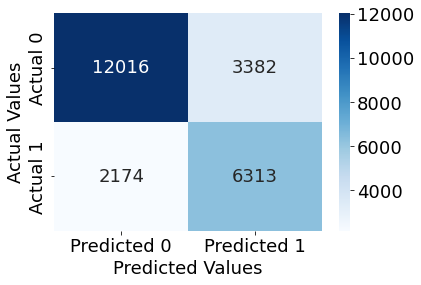

In [98]:
# Evaluating Model 6 on train data
confusion_matrix_data(Xstd, y, ridge, cutoff = 0.4)

Classification accuracy = 76.1%
Precision = 65.2%
TPR or Recall = 72.6%
FNR = 27.4%
FPR = 22.0%
ROC-AUC = 86.2%


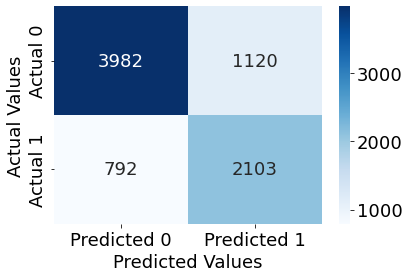

In [99]:
# Evaluating Model 6 on test data
confusion_matrix_data(Xtest_std, test.booking_status, ridge, cutoff = 0.4)

In [100]:
#Predict the values using the ridge model
pred_values_6 = ridge.predict(Xtest_std)

### Model 7) Lasso
*By Hoda Fakhari*

In [ ]:
# Model 7) Lasso

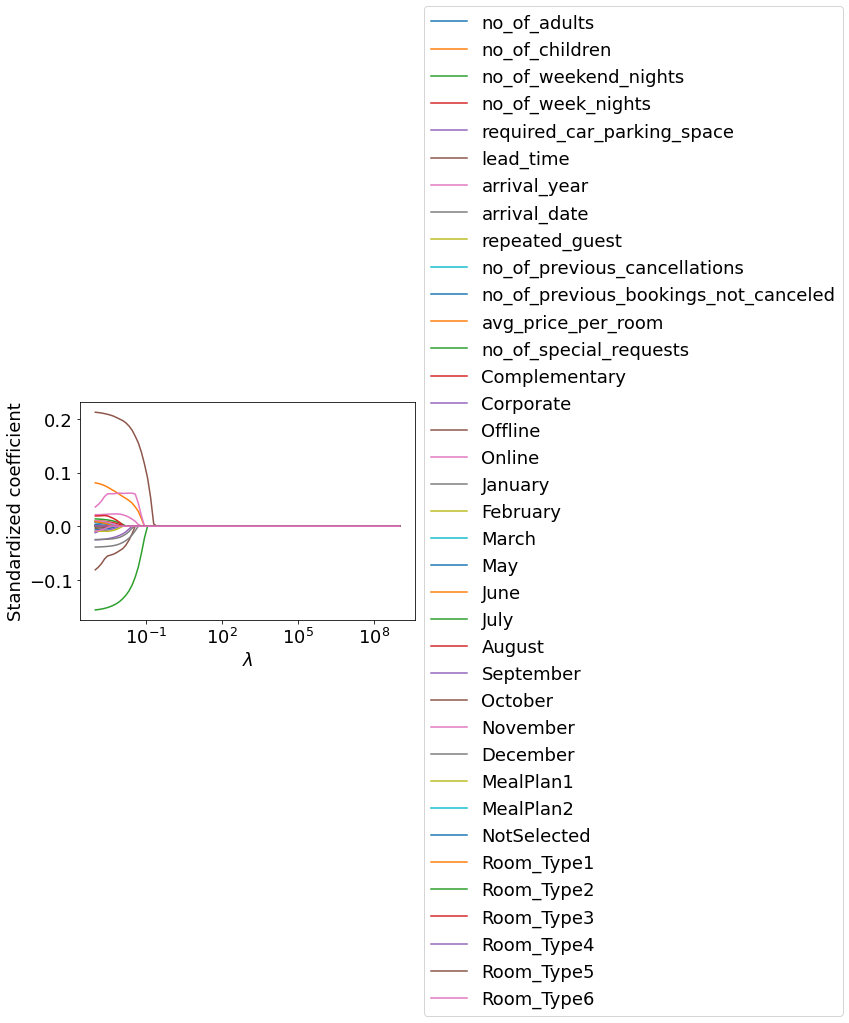

In [101]:
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 
                               'arrival_month', 'room_type_reserved']), loc='center left', bbox_to_anchor=(1, 0.5));

In [102]:
#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.00014665831391950227

In [103]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso = lasso.fit(Xstd, y)

In [104]:
lasso_coeff = pd.DataFrame(lasso.coef_, columns = ['coefficients'])
lasso_coeff['predictors'] = X.columns
lasso_coeff

,coefficients,predictors
0,0.008796,no_of_adults
1,0.013093,no_of_children
2,0.014314,no_of_weekend_nights
3,0.010897,no_of_week_nights
4,-0.026475,required_car_parking_space
5,0.214581,lead_time
6,0.020514,arrival_year
7,0.003092,arrival_date
8,0.000000,repeated_guest
9,-0.000109,no_of_previous_cancellations


Classification accuracy = 76.7%
Precision = 65.1%
TPR or Recall = 74.2%
FNR = 25.8%
FPR = 21.9%
ROC-AUC = 87.2%


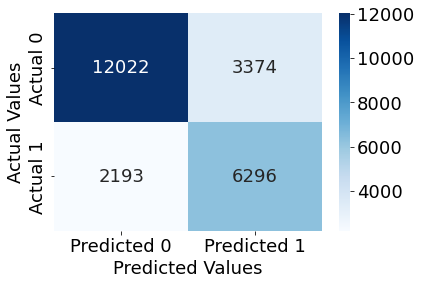

In [105]:
# Evaluating Model 7 on train data
confusion_matrix_data(Xstd, y, lasso, cutoff = 0.4)

Classification accuracy = 76.1%
Precision = 65.2%
TPR or Recall = 72.4%
FNR = 27.6%
FPR = 21.9%
ROC-AUC = 86.2%


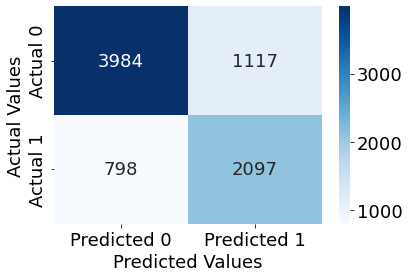

In [106]:
# Evaluating Model 7 on test data
confusion_matrix_data(Xtest_std, test.booking_status, lasso, cutoff = 0.4)

In [107]:
#Predict the values using the lasso model
pred_values_7 = lasso.predict(Xtest_std)

### Code fitting the final model
*By Elena Llaguno Cantu*

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [120]:
df = pd.DataFrame()
df['Model_1'] = pred_values_1
df['Model_2'] = pred_values_2
df['Model_3'] = pred_values_3
df['Model_4'] = pred_values_4
df['Model_5'] = pred_values_5
df['Model_6'] = pred_values_6
df['Model_7'] = pred_values_7

In [121]:
def applying_cutoff(df): 
    for col in df.columns:
        for index, value in df[col].iteritems():
            if value < 0.5:
                df.at[index, col] = 0
            else:
                df.at[index, col] = 1  
            
    return df

In [122]:
df = applying_cutoff(df)
df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7
28112,1.0,0.0,0.0,1,0,0.0,0.0
6482,0.0,0.0,0.0,1,1,0.0,0.0
12183,0.0,0.0,0.0,1,1,0.0,0.0
34739,0.0,0.0,0.0,0,0,0.0,0.0
2375,1.0,1.0,1.0,0,0,1.0,1.0
...,...,...,...,...,...,...,...
28804,0.0,0.0,0.0,0,0,0.0,0.0
9727,0.0,0.0,0.0,0,0,0.0,0.0
36076,1.0,1.0,1.0,0,1,1.0,1.0
25340,0.0,1.0,0.0,0,0,0.0,0.0


In [123]:
# averaging the model results function
def combining_results(df): 
    df['sum'] = df.sum(axis=1)

    for index, row in df.iterrows():
        if row['sum'] >= 3:
            df.at[index, 'sum'] = 1
        else:
            df.at[index, 'sum'] = 0
        
    pred_values = df['sum']
    
    return pred_values

In [124]:
final_values = combining_results(df)
final_values

28112    0.0
6482     0.0
12183    0.0
34739    0.0
2375     1.0
        ... 
28804    0.0
9727     0.0
36076    1.0
25340    0.0
34948    0.0
Name: sum, Length: 9069, dtype: float64

In [125]:
# Modified confusion matrix function

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 79.2%
Precision = 72.3%
TPR or Recall = 61.1%
FNR = 38.9%
FPR = 11.7%
ROC-AUC = 74.7%


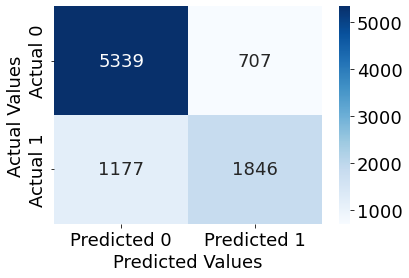

In [126]:
# Evaluating final model on test data
confusion_matrix_data_modified(final_values,test.booking_status,0.45)

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.

## Overbooking Formula

Currently, most hotels overbook anywhere between 2%, 3%, up to 10%, and 15%. The higher the overbooking percentage, the more likely a customer is to have to be rebooked to a different hotel. This would lead to customers dissatisfaction due to the constant moving pieces. 

The true positive rate is aroun 60%, which means that 60% of the customers predicted to cancel will cancel. To edge on the safer end, we would recommend overbooking approximately 50% the number of customers predicted to cancel for the night.

In addition, the true negative rate or the specificity of the model is 1 - FPR = ~90%, which means that approximately 90% of customers predicted to not cancel follow through with their reservation. This means that using our model, we will miss guess around 10% of customers who are going to follow through. Once again, to edge on the safer end, we would recommend overbooking approximately 2% the number of customers predicted to follow through for the night. This would be best for the hotel to maximizes the profit. 

In addition, we would recommend that the customer round down the number of rooms to overbook, just to edge on the safer side

In [65]:
# Modified confusion matrix function

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [66]:
# Calling the function
confusion_matrix_data_modified(final_values,test.booking_status,0.45)

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: The dimension of bins must be equal to the dimension of the  sample x.

In [ ]:
# Function to give a model's tpr

def confusion_matrix_data_modified_tpr(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    return tpr

In [ ]:
test_tpr = confusion_matrix_data_modified_tpr(final_values,test.booking_status,0.45)
test_tpr

In [ ]:
# Function to give a model's tnr

def confusion_matrix_data_modified_tnr(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tnr = 1 - fpr
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    return tnr

In [ ]:
test_tnr = confusion_matrix_data_modified_tnr(final_values,test.booking_status,0.45)
test_tnr

In [ ]:
test_0_1 = test.booking_status.value_counts()
test_0_1.head()

In [ ]:
# Overbooking formula for the number of rooms they should overbook

import math

def overbooking_formula(tpr, tnr, test_0_1, test):
    min_price = test.avg_price_per_room.min()
    max_price = test.avg_price_per_room.max()
    overbooking = test_0_1[1] * (tpr - 0.1) + test_0_1[0] * (1 - tnr - 0.1)
    overbooking = math.floor(overbooking)
    lower = overbooking * min_price
    higher = overbooking * max_price
    print('The client should overbook', overbooking, 'rooms.')
    print('The client would save at least $', lower, ', but this number can also go up to $', higher)

In [ ]:
overbooking_formula(test_tpr, test_tnr, test_0_1, test)